In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp,Statevector,state_fidelity
from qiskit_algorithms import VarQITE, TimeEvolutionProblem
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple

In [2]:
#define the transverse field ising hamiltonian
def TFIM(N,J,H):
    zz_terms = []
    x_terms = []
    for i in range(N):
        zz_term = ['I']*N
        zz_term[i] = 'Z'
        zz_term[(i+1)%N] = 'Z'
        zz_terms.append(''.join(zz_term))

        x_term = ['I']*N
        x_term[i] = 'X'
        x_terms.append(''.join(x_term))

    Ham = SparsePauliOp(zz_terms, coeffs=[-J]*N) + SparsePauliOp(x_terms, coeffs=[-H]*N)
    return Ham

In [3]:
# Hamiltonian parameters
n_qubits = 8
J = 1
h = 1

In [4]:
# Define Imaginary McLachlan Principle for Variational Time Evolution using Qiskit Function
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
var_principle = ImaginaryMcLachlanPrinciple()

# Define Hamiltonian and Paprameters
hamiltonian = TFIM(n_qubits, J, h)

# Choose an ansatz
ansatz = EfficientSU2(n_qubits, reps=2,skip_final_rotation_layer=True, entanglement='linear')

# Initial parameters (variation anstaz)
init_param_values = {param: np.pi/3 for param in ansatz.parameters}

# Set up evolution problem (fix: add aux_operators)
time = 4.0
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=[hamiltonian])

#  VarQITE using the github function
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator(),num_timesteps=40)

# Evolve the system
evolution_result = var_qite.evolve(evolution_problem)

/tmp/ipykernel_2035242/2594392702.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator(),num_timesteps=40)



Exact Ground State Energy: -10.251662


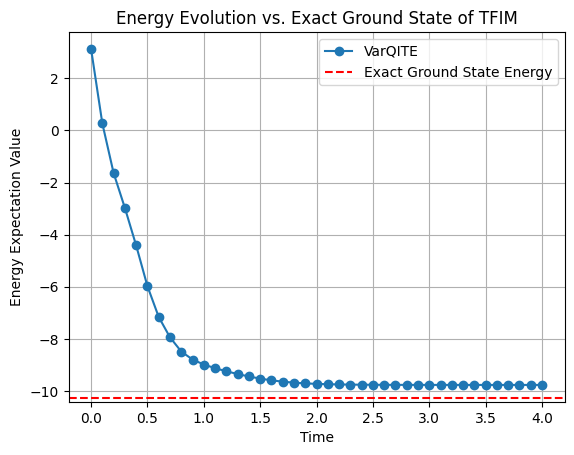

In [5]:
# Extract times and energy values from VarQITE evolution
times = evolution_result.times
energies = [obs[0][0] for obs in evolution_result.observables]  # Extract energy expectation values

# Compute exact ground state energy using diagonalization
H_matrix = hamiltonian.to_matrix()
exact_energies, exact_states = np.linalg.eigh(H_matrix)
exact_ground_state_energy = np.min(exact_energies)


print(f"\nExact Ground State Energy: {exact_ground_state_energy:.6f}")

# Plot 
plt.plot(times, energies, marker='o', linestyle='-', label="VarQITE")
plt.axhline(y=exact_ground_state_energy, color='r', linestyle='--', label="Exact Ground State Energy")  # Add horizontal line
plt.xlabel("Time")
plt.ylabel("Energy Expectation Value")
plt.title("Energy Evolution vs. Exact Ground State of TFIM")
plt.legend()
plt.grid(True)
plt.savefig(f"energy_evolution_vs_exact_ground_state_{n_qubits}_spins_reps_1.5.png", dpi=300)
plt.show()

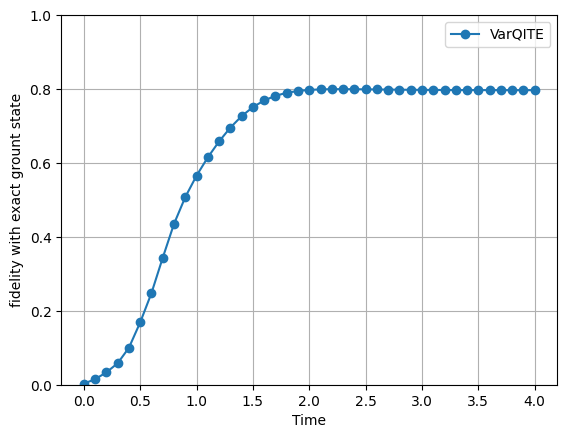

In [8]:
# Compute fidelity to exact ground state
intermediate_fidelities = []

for values in evolution_result.parameter_values:
    state = Statevector(ansatz.assign_parameters(dict(zip(ansatz.parameters,values))))
    intermediate_fidelities.append(state_fidelity(state,exact_states[:,0]))

# Plot 
plt.plot(times, intermediate_fidelities, marker='o', linestyle='-', label="VarQITE")
plt.xlabel("Time")
plt.ylabel("fidelity with exact grount state")
plt.legend()
plt.grid(True)
plt.ylim([0,1])
plt.savefig(f"fidelity_evolution_{n_qubits}_spins_reps_1.5.png",dpi=300)
plt.show()

# Printing the ansatz

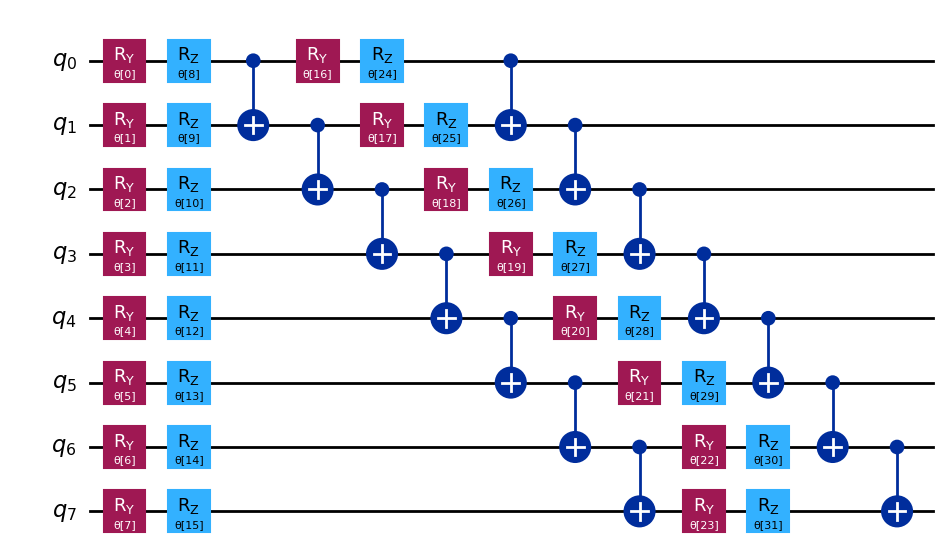

In [7]:
ansatz.decompose().draw('mpl')